# Reading measured data from Polytec vibrometer


This script connects to a NI USB-6363 Data Acquisition board to generate an actuation signal, and measure the respective vibrometer data of a Polytec MSA-500 system


1. Actuation signal is generated by the DAQ
2. A copy reference of the actuation signal is acquired by the DAQ
3. The physical actuation signal is amplified and drives the device under test
4. The Polytec MSA-500 is configured using the system software, and the Detector and other configurations must be defined in this script
5. The script loop generates the actuation signal, and measures the corresponding reference and vibrometer signal
6. The acquired signal and configuration settings are stored in a json file


Reads the json file and plots amplitude frequency response and spectrum


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import constants as const
import nidaqmx as ni

import time
# Creating the actuation signal
from datetime import datetime
import json
from json import JSONEncoder

from scipy import signal, fft
from matplotlib import colors

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)


In [2]:
def open_data_file(filename):
    # Load data from json file
    with open(filename, 'r') as fp:
        json_dict = json.load(fp)
    return json_dict
        
def load_frequency_response(filename):
    """Opens the data file and extracts frequency and amplitude"""
    data = open_data_file(filename)
    
    frequencies = np.array(data['signal_frequencies'])
    amplitude = np.array(data['vibrometer_amplitude'])
    return (frequencies, amplitude)

def load_frequency_deflection_spectrum(filename):
    """ Opens the data file, calcualtes the spectrum and returns spectrometer data"""
    data = open_data_file(filename)


    # Looping over signal and calculating FFT for each
    vibration_spectrum = []

    frequencies = np.array(data['signal_frequencies'])
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = data['signal'][str(i)]['vibrometer']
        ref_I = data['signal'][str(i)]['ref_I']
        time = data['signal_time']

        dt = np.diff(time[:2])
        vib_fft = fft.fft(vibrometer, )

        vibration_freqs = fft.fftfreq(vib_fft.size, d=dt)
        vib_fft = fft.fftshift(vib_fft)
        vibration_freqs = fft.fftshift(vibration_freqs)


        vibration_spectrum.append(vib_fft)
        # plt.plot(freqs,vib_fft)


    vibration_spectrum = np.array(vibration_spectrum).T

    spectrum_abs = np.abs(fft_list)
    spectrum_phase = np.angle(fft_list)
    
    return (frequencies, vibration_freqs, vibration_spectrum)


    
def load_time_signal_data_concatenated(filename):
    """ Opens the data file, reads signal data and concatenates in a single time signal"""
    data = open_data_file(filename)

    vibrometer_list = []
    ref_I_list = []
    for i, frequency in enumerate(data['signal_frequencies']):
        vibrometer = np.array(data['signal'][str(i)]['vibrometer'])
        vibrometer_list.append(vibrometer)
        ref_I = data['signal'][str(i)]['ref_I']

    vibrometer = np.array(vibrometer_list).flatten()
    
    time = np.arange(len(vibrometer))*data['daq_input_sample_interval']
    
    return (time, vibrometer)

## Linearization function

In [3]:
k = 1851
area = 9.3e-8
gap = 2e-6

def linearization_function(x, gain=53, k=1851, area=9.3e-8, gap=2e-6):
    a = np.sqrt(2*k*x/(const.epsilon_0*area))*(gap-x)/gain
    
    return a




### Amplitude response fit

From Practical MEMS:

(B.11):

$$ |x_0| = \frac{|F_0|/m}{\sqrt{ \left(\omega^2-\omega_0^2\right)^2 +\left(\omega\omega_0/Q\right)^2   }}  = \frac{|F_0|/k}{\sqrt{ \left(1-\frac{\omega^2}{\omega_0^2}\right)^2 +\left(\frac{\omega}{Q\omega_0}\right)^2   }}  $$

In [4]:
from scipy.optimize import curve_fit

def fit_amplitude_response(w, F0, k, w0, Q):
    return np.abs(F0)/k/(np.sqrt( np.power(1-np.power(w/w0,2),2) + np.power(w/(Q*w0),2) ))


# popt, pcov = curve_fit(func, xdata, ydata)

['FDPanel_T09_F5.2_top_actuation_20.8V.json', 'FDPanel_T09_F5.2_top_actuation_20.9V.json', 'FDPanel_T09_F5.2_top_actuation_44.8V.json', 'FDPanel_T09_F5.2_top_actuation_53.3V.json', 'FDPanel_T09_F5.2_top__actuation_18.8V.json', 'FDPanel_T09_F5.2_top__actuation_29.2V.json', 'FDPanel_T09_F5.2_top__actuation_34.2V.json', 'FDPanel_T09_F5.2_top__actuation_38.4V.json', 'FDPanel_T09_F5.2_top__actuation_40.3V.json', 'FDPanel_T09_F5.2_top__actuation_45.2V.json', 'FDPanel_T09_F5.2_top__actuation_48.0V.json']
saved to DAQ_outputs//FDPanel_T09_F5.2_top__actuation.png


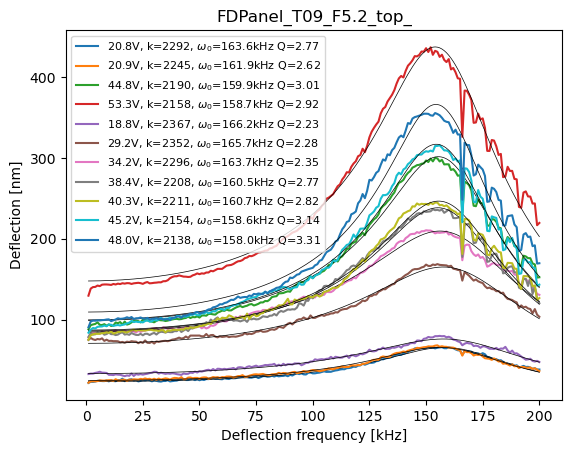

In [5]:
from scipy.optimize import curve_fit

def fit_amplitude_response(w, F0, k, w0, Q):
    return np.abs(F0)/k/(np.sqrt( np.power(1-np.power(w/w0,2),2) + np.power(w/(Q*w0),2) ))


data_path = 'DAQ_outputs//'

file_prefix = "FDPanel_T09_F10.1_top"
file_prefix = "FDPanel_T09_F5.2_bottom"
file_prefix = "FDPanel_T09_F5.2_top"


files = os.listdir(data_path)
files = [d for d in files if ".json" in d]
files = [d for d in files if file_prefix in d]
files = [d for d in files if "actuation" in d]

print(files)
# Loop through existing files
for file in files:
    filename = os.path.join(data_path, file)
    data = open_data_file(filename)

    try:
        if data['measurement_type'] not in ["interferometer", "linearization"]:
            continue
    except:
        if 'interferometer_system' not in data.keys():
            continue

    
    frequencies, amplitude = load_frequency_response(filename)
    actuation_max_voltage = data['actuation_max_voltage']
    actuation_max_displacement = data['actuation_max_displacement']
    
        
    xdata,ydata = frequencies/1e3, amplitude/1e-9
    # fitting
    popt, pcov = curve_fit(fit_amplitude_response, xdata, ydata)
    
    F0,k,w0, Q = popt
    fitdata = fit_amplitude_response(xdata, *popt)
    w0 = w0*1e3
    
    if 'linearization_model_mass' in data.keys():
        
        mass = data['linearization_model_mass']
    else:
        mass = 2.17e-9
    new_k = np.power(2*np.pi*w0,2)*mass
    label = '%0.1fV %0.1fnm'%(actuation_max_voltage, actuation_max_displacement/1e-9)
    # label = '%0.1fV %0.1fnm, k=%d, $\omega_0$=%0.1fkHz Q=%0.2f'%(actuation_max_voltage, actuation_max_displacement/1e-9, new_k, w0/1e3, Q)
    label = '%0.1fV, k=%d, $\omega_0$=%0.1fkHz Q=%0.2f'%(actuation_max_voltage, new_k, w0/1e3, Q)
    
    
    if 'linearization' in filename:
        plt.plot(frequencies/1e3, amplitude/1e-9, label=label, c='k')
    else:
        plt.plot(frequencies/1e3, amplitude/1e-9, label=label)
    

    plt.plot(xdata, fitdata, c='k', lw=0.5)
    
    if 'device_name' in data.keys():
        title = data['device_name']
        plt.title(title)
        output_figname = data['device_name']+"_actuation.png"
plt.xlabel("Deflection frequency [kHz]")
plt.ylabel("Deflection [nm]")
plt.legend(fontsize=8)


outfilename = os.path.join(data_path, output_figname)
plt.savefig(outfilename, dpi=300)
print("saved to", outfilename)

### Loading the data

In [5]:
data_path = 'DAQ_outputs//'

files = os.listdir(data_path)
print(files)

files = [d for d in files if ".json" in d]

print(files)
# Loop through existing files
for file in files:
    filename = os.path.join(data_path, file)
    
    # Load data from json file
    with open(filename, 'r') as fp:
        json_dict = json.load(fp)
        
        
        
    data = json_dict
    # print(data.keys())


['FDPanel_T09_F10.1_top_actuation_29.2V.json', 'FDPanel_T09_F10.1_top_actuation_40.3V.json', 'FDPanel_T09_F10.1_top_actuation_43.7V.json']
['FDPanel_T09_F10.1_top_actuation_29.2V.json', 'FDPanel_T09_F10.1_top_actuation_40.3V.json', 'FDPanel_T09_F10.1_top_actuation_43.7V.json']


## Plot frequency response

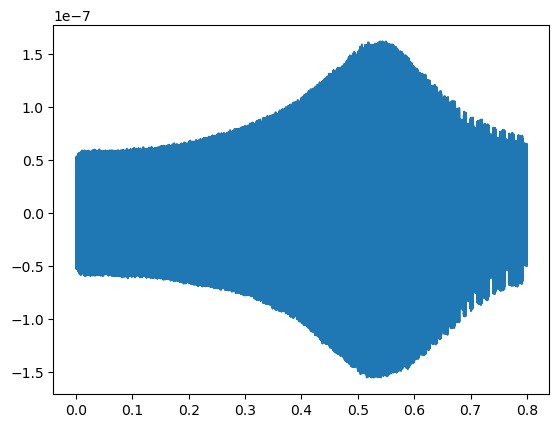

In [7]:
time, vibrometer = load_time_signal_data_concatenated(filename)

plt.plot(time, vibrometer)

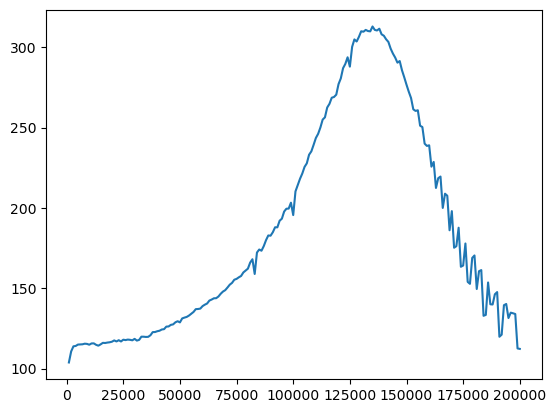

In [8]:

# Loop over data
# frequencies = np.array(data['signal_frequencies'])
# amplitude = np.array(data['vibrometer_amplitude'])

frequencies, amplitude = load_frequency_response(filename)


plt.figure()
plt.plot(frequencies, amplitude/1e-9)
# plt.plot(frequencies, vib_amp)

# (amplitude-vib_amp)/amplitude*100

# Plot spectrogram


In [289]:
np.percentile(sig, 99)

0.5693563763574337

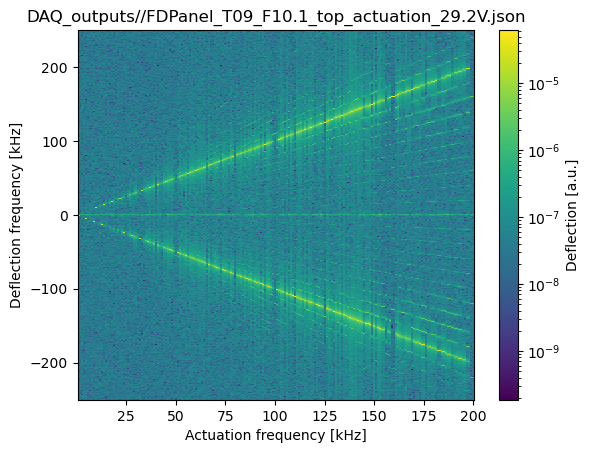

In [309]:

frequencies, vibration_freqs, vibration_spectrum = load_frequency_deflection_spectrum(filename)

vibration_spectrum = np.abs(vibration_spectrum)

plt.title(filename)
plt.pcolormesh(frequencies/1e3, vibration_freqs/1e3, vibration_spectrum, norm=colors.LogNorm(vmin=vibration_spectrum.min(), vmax=vibration_spectrum.max()))
# plt.pcolormesh(f_list, freqs, mag_fft.T)

plt.xlabel("Actuation frequency [kHz]")
plt.ylabel("Deflection frequency [kHz]")

plt.colorbar(label='Deflection [a.u.]')
# plt.colorbar(label='Actuation voltage [a.u.]')



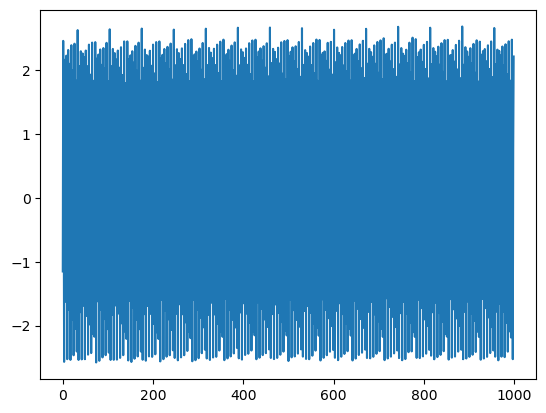

In [228]:
# def set_output_signal(max_displacement, frequency):

frequency = 140e3
max_displacement = 100e-9

fs = data_dict['daq_output_fs']
fs = 2e6

t_max = 10/frequency

N = int(t_max*fs)
t = np.linspace(0,t_max,N)



data = generate_waveform_signal(t, frequency, max_displacement)

with ni.Task() as read_task, ni.Task() as write_task, ni.Task() as trigger_task:

    # set channels
    # for chan_input, chan_name in zip(data_dict['daq_input_channels'], data_dict['daq_input_channel_names']):
    read_task.ai_channels.add_ai_voltage_chan("Dev1/ai2")

    # for chan_output, chan_name in zip(data_dict['daq_output_channels'], data_dict['daq_output_channel_names']):
    write_task.ao_channels.add_ao_voltage_chan("Dev1/ao0")


    # Set sampling frequency and Continuous output mode to continuously generate the same waveform
    write_task.timing.cfg_samp_clk_timing(fs, sample_mode=ni.constants.AcquisitionType.CONTINUOUS)

    # Set the acquisiton sampling frequency with a finite acquisition
    read_task.timing.cfg_samp_clk_timing(data_dict['daq_input_fs'], sample_mode=ni.constants.AcquisitionType.FINITE, samps_per_chan=1000)

    # Set the acquisiton trigger to start synchronized with the writing of the waveform
    # write_task.triggers.start_trigger.cfg_dig_edge_start_trig(term_trigger, trigger_edge=ni.constants.Edge.RISING)
    read_task.triggers.start_trigger.cfg_dig_edge_start_trig(write_task.triggers.start_trigger.term, trigger_edge=ni.constants.Edge.FALLING)

#     # set an arbitrary TICKS time after write
    wait_time_after_write = 5000000

    read_task.triggers.start_trigger.delay = wait_time_after_write
    # print(read_task.triggers.start_trigger.delay_units)

    # Write waveform data to output buffer
    write_task.write(data)
    
    # write_task.start()
    
    
#     # Get the actual sample rate and sample interval from the daq
#     sample_clk_rate = read_task.timing.samp_clk_rate
#     dt = 1/sample_clk_rate


#     data_dict['daq_input_sample_rate'] = sample_clk_rate
#     data_dict['daq_input_sample_interval'] = dt
#     # print(sample_clk_rate, dt)

    read_task.start()

    write_task.start()



#     # Read data
    data = read_task.read(number_of_samples_per_channel=ni.constants.READ_ALL_AVAILABLE)


#     while 1:
#         continue


#     # set output to 0
#     write_task.stop()
#     write_task.write([0,0])
#     write_task.start()
plt.plot(data)

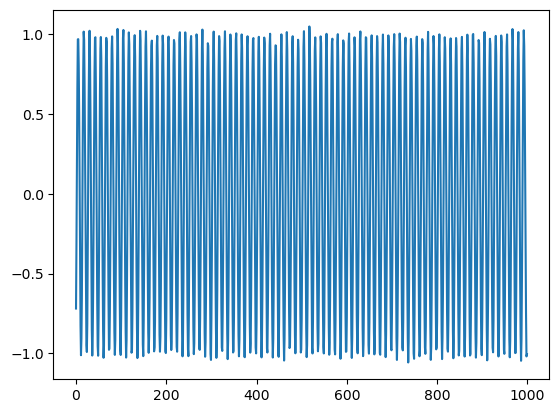

In [226]:
plt.plot(data)

In [194]:
# plt.figure(figsize=(10,2))


    reference = np.array(data[0])
    vibrometer = np.array(data[1])

    scale_reference = 53 # V/V

    vibrometer_detector = 50 # nm/V

    scale_vibrometer = -1* vibrometer_detector

    reference *= scale_reference
    vibrometer *= scale_vibrometer
    vibrometer -= vibrometer.min()

    t = np.arange(len(reference))*dt
    
    
    reference_list.append(reference)
    time_list.append(t)
    vibrometer_list.append(vibrometer)
    

fig, axes = plt.subplots(3,1,)

plt.sca(axes[0])

plt.plot(t, reference, '-')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")

plt.sca(axes[1])
plt.plot(t, vibrometer, '-')
plt.xlabel("Time [s]")
plt.ylabel("Voltage [nm]")

plt.sca(axes[2])
plt.plot(reference, vibrometer, '-')
plt.xlabel("Voltage [V]")
plt.ylabel("Deflection [nm]")

    

IndentationError: unexpected indent (3219415832.py, line 4)

199
199


ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

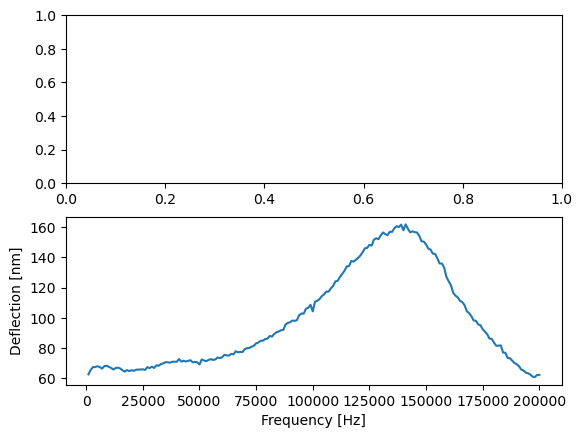

In [62]:

fig, axes = plt.subplots(2,1,)


max_deflection = []
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list, reference_list, vibrometer_list)):
    
    max_deflection.append(vibrometer.max())
    
    # plt.sca(axes[0])
    # plt.plot(reference, vibrometer, '-')
    # plt.xlabel("Voltage [V]")
    # plt.ylabel("Deflection [nm]")
print(i)
plt.sca(axes[1])

plt.plot(f_list, max_deflection)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Deflection [nm]")

max_deflection = []
newi = i+1
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list[newi:], reference_list[newi:], vibrometer_list[newi:])):
    
    max_deflection.append(vibrometer.max())
    
    # plt.sca(axes[0])
    # plt.plot(reference, vibrometer, '-')
    # plt.xlabel("Voltage [V]")
    # plt.ylabel("Deflection [nm]")
print(i)
plt.sca(axes[1])

plt.plot(f_list, max_deflection)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Deflection [nm]")


In [82]:
from scipy import signal, fft
from matplotlib import colors


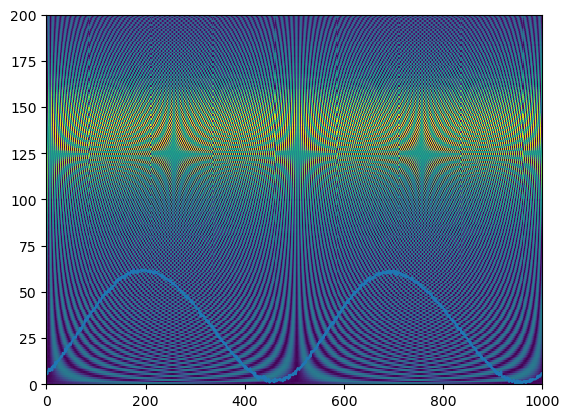

In [83]:
z = np.array(vibrometer_list)
z.shape

plt.pcolormesh(z)

plt.plot(z[0,:])



In [124]:

fft_list = []
# for vib in vibrometer_list[:]:
for i, (f_displacement, time, reference, vibrometer) in enumerate(zip(f_list,time_list, reference_list, vibrometer_list)):

    dt = np.diff(time[:2])
    vib_fft = fft.rfft(vibrometer, norm="ortho")
    
    freqs = fft.fftfreq(vib_fft.size, d=dt)
    vib_fft = fft.fftshift(vib_fft)
    freqs = fft.fftshift(freqs)
    
    vib_fft = abs(vib_fft)
    vib_fft /= vib_fft.max()
    
    fft_list.append(vib_fft)
    # plt.plot(freqs,vib_fft)
    
    
fft_list = np.array(fft_list)

mag_fft = abs(fft_list)
    

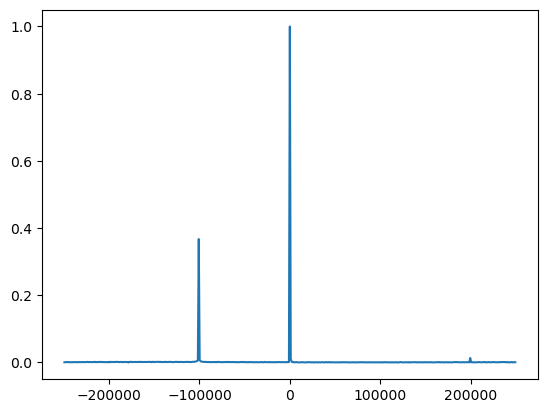

In [126]:
# plt.plot(freqs, vib_fft)
plt.plot(freqs,abs(vib_fft))

In [127]:
fft_list.shape, freqs.shape, f_list.shape, mag_fft

((200, 501),
 (501,),
 (200,),
 array([[5.07799081e-04, 7.96450782e-04, 2.70782286e-04, ...,
         1.92291968e-04, 6.76869730e-04, 1.07751972e-03],
        [4.60822899e-04, 6.25596610e-04, 2.50390976e-04, ...,
         7.22589092e-04, 6.65582645e-04, 2.47294450e-04],
        [6.96251518e-04, 6.90909064e-05, 7.73929203e-05, ...,
         5.87329845e-04, 1.84380416e-04, 4.93865568e-04],
        ...,
        [8.84237032e-04, 1.36445935e-03, 1.36343888e-03, ...,
         1.05822694e-03, 1.12894729e-03, 5.22657820e-04],
        [5.35711349e-04, 1.29978417e-03, 1.05121316e-03, ...,
         7.51890259e-04, 1.59805398e-03, 8.22853656e-04],
        [5.27065088e-04, 1.04004776e-03, 1.21601931e-03, ...,
         9.93045083e-04, 7.09756805e-04, 7.75676626e-04]]))

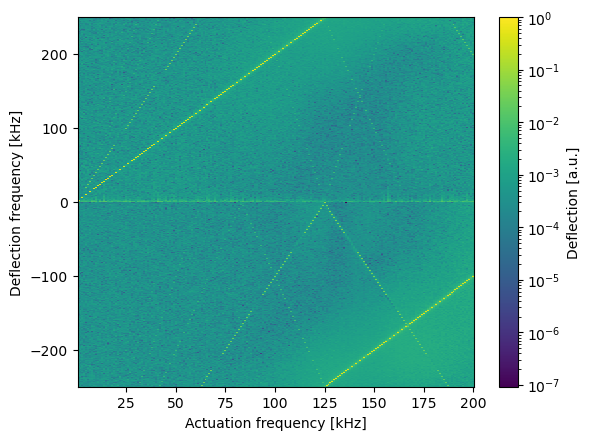

In [128]:
plt.pcolormesh(f_list/1e3, freqs/1e3, mag_fft.T, norm=colors.LogNorm(vmin=mag_fft.min(), vmax=mag_fft.max()))
# plt.pcolormesh(f_list, freqs, mag_fft.T)

plt.xlabel("Actuation frequency [kHz]")
plt.ylabel("Deflection frequency [kHz]")

plt.colorbar(label='Deflection [a.u.]')

In [130]:
import json

In [129]:
fs = fs_input
nfft = 2048
noverlap = 120
nperseg = 128
f, t, Sxx = signal.spectrogram(z, fs=fs, nperseg=nperseg, nfft=nfft, noverlap=noverlap)

# plt.pcolormesh(Sxx)

In [47]:
Sxx.shape, f.shape, t.shape

((400, 1025, 110), (1025,), (110,))

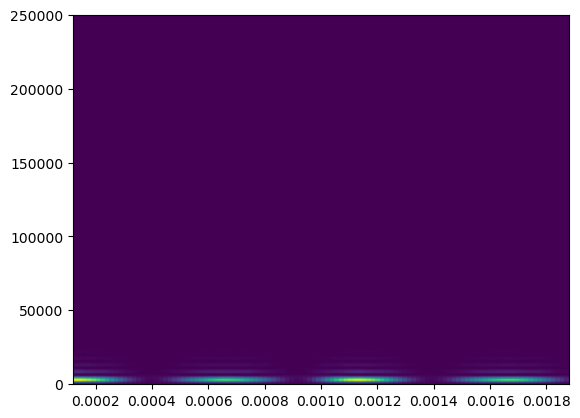

In [48]:
plt.pcolormesh(t,f, Sxx[0])

## Reading audio from microphone

In [43]:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

* recording


In [14]:
"abc" in "abcdef"

True

Selected device: 1 Line (UMIK-2)


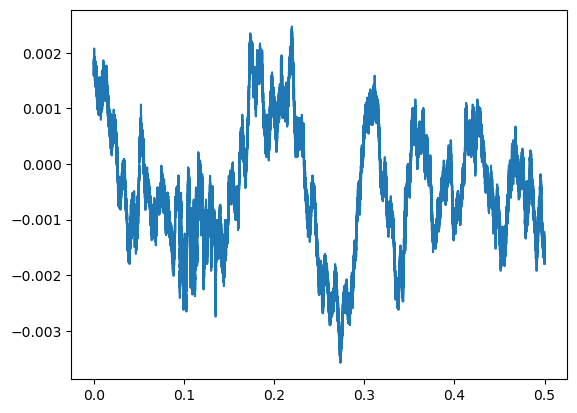

In [39]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav


# print(sd.query_devices())

device_list = sd.query_devices()

# find and select index of Line (UMIK-2)
device_str = "Line (UMIK-2), MME"

for device in device_list:
    # print(device)
    if device_str in device["name"]:
        device_name = device["name"]
        device_index = device["index"]
        break
print("Selected device:",device_index,device_name)
sd.default.device = device_index



fs_recording = 192000
dt_recording = 1/fs_recording
duration = 0.5 #

N_recording = int(fs_recording*duration)

# Start recording:

recording = sd.rec(N_recording, samplerate=fs_recording, channels=1, dtype='float64')
time_recording = np.arange(len(recording))*dt_recording

# wait for recording to complete
sd.wait()


plt.plot(time_recording, recording)

In [26]:
fs=192000*2
duration = 0.5  # seconds


recording = sd.rec(duration * fs, samplerate=fs, channels=1,dtype='float64')
print ("Recording Audio from speaker")
sd.wait()
plt.plot(recording)
# plt.plot(myrecording[:,1])
print ("Audio recording complete , Play Audio")
sd.play(recording, fs)
sd.wait()
print ("Play Audio Complete")

TypeError: 'float' object cannot be interpreted as an integer

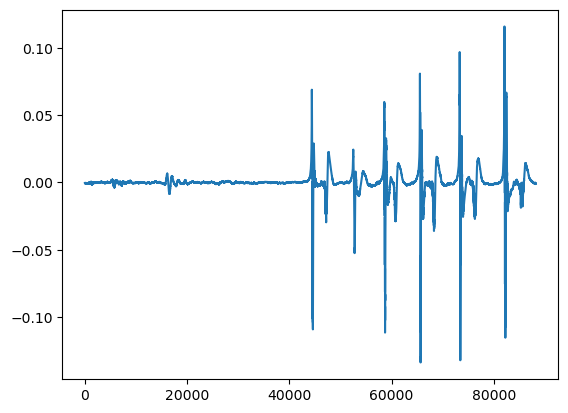

In [127]:
plt.plot(myrecording[:,0])